# Model v1
A very simple model, using arbitary thresholds and no backtesting.

In [1]:
import stocks
import matplotlib.pyplot as plt
import datetime
import pandas as pd

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
symbols = stocks.symbols()

In [4]:
stock_dct = {s:stocks.get(s) for s in symbols}

In [5]:
latest_stock_data = stocks.get_latest_stock_data(list(stock_dct.keys()))

In [6]:
%%capture
for k,v in stock_dct.items():
    v.update()
    historic = v.historic_data
    start_date = historic.index.min().date()
    v.start_date = start_date
    v.meta = latest_stock_data[k]

In [7]:
today = datetime.date.today()

In [8]:
for k,v in stock_dct.items():
    age = (today - v.start_date).days / 365
    v.age = age

In [9]:
age_lst = [(k, v.age) for k,v in stock_dct.items()]

In [10]:
age_lst.sort(key=lambda x: x[1])

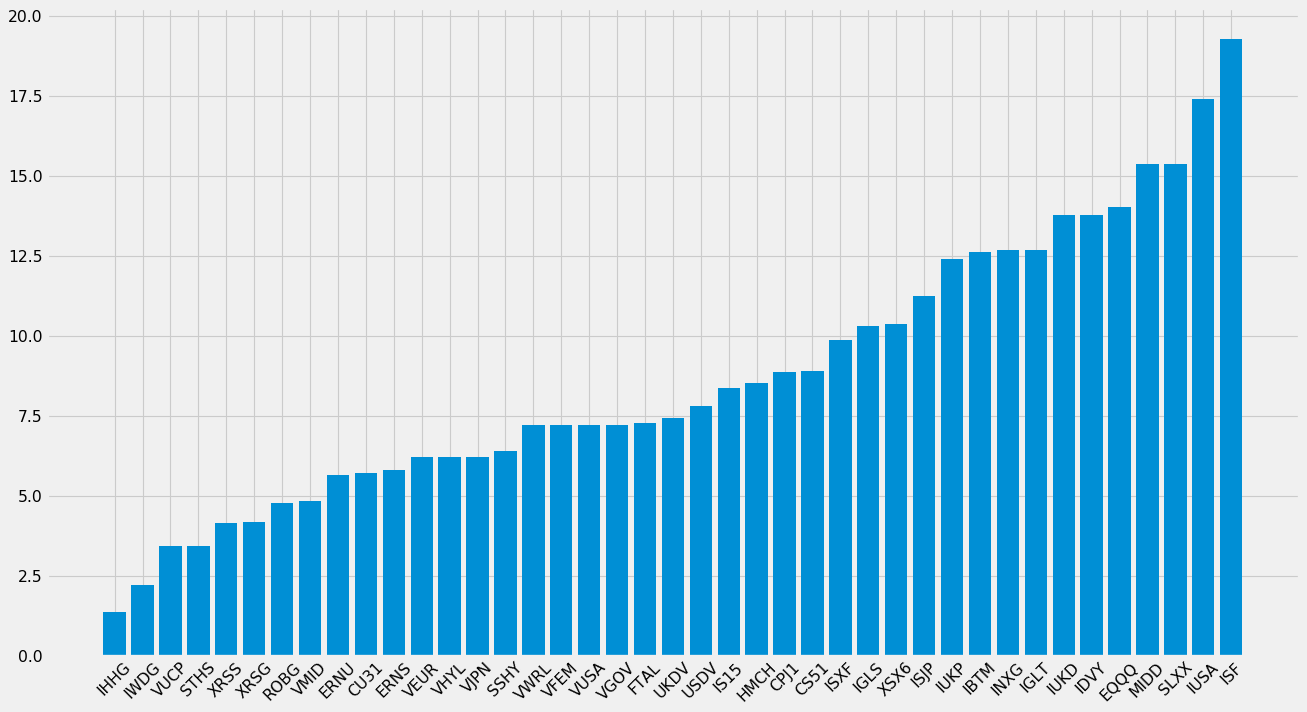

In [11]:
plt.figure(figsize=(18,10), dpi= 80)
plt.bar(range(len(age_lst)), [v[1] for v in age_lst], align='center')
plt.xticks(range(len(age_lst)), [v[0] for v in age_lst])
plt.xticks(rotation=45)
plt.show()

In [12]:
gt_10yrs = [i[0] for i in age_lst if i[1] >= 10]

In [13]:
import statistics

In [14]:
def median_return(data, years):
    
    close_xyrs = data.Close[ data.index.year > max(data.index.year) - years ]
    
    inc_lst = []
    for yr in set(close_xyrs.index.year):
        yr_close = data.Close[ data.index.year == yr ]
        increase = (yr_close[-1] - yr_close[0]) / yr_close[0]
        inc_lst.append(increase)
        
    return statistics.median(inc_lst)
    

In [15]:
%%capture
for k,v in stock_dct.items():
    historic = v.historic_data
    v.median_return = median_return(historic, 10)

In [16]:
return_lst = [(k, v.median_return) for k,v in stock_dct.items() if k in gt_10yrs]

In [17]:
return_lst.sort(key=lambda x: x[1], reverse=True)

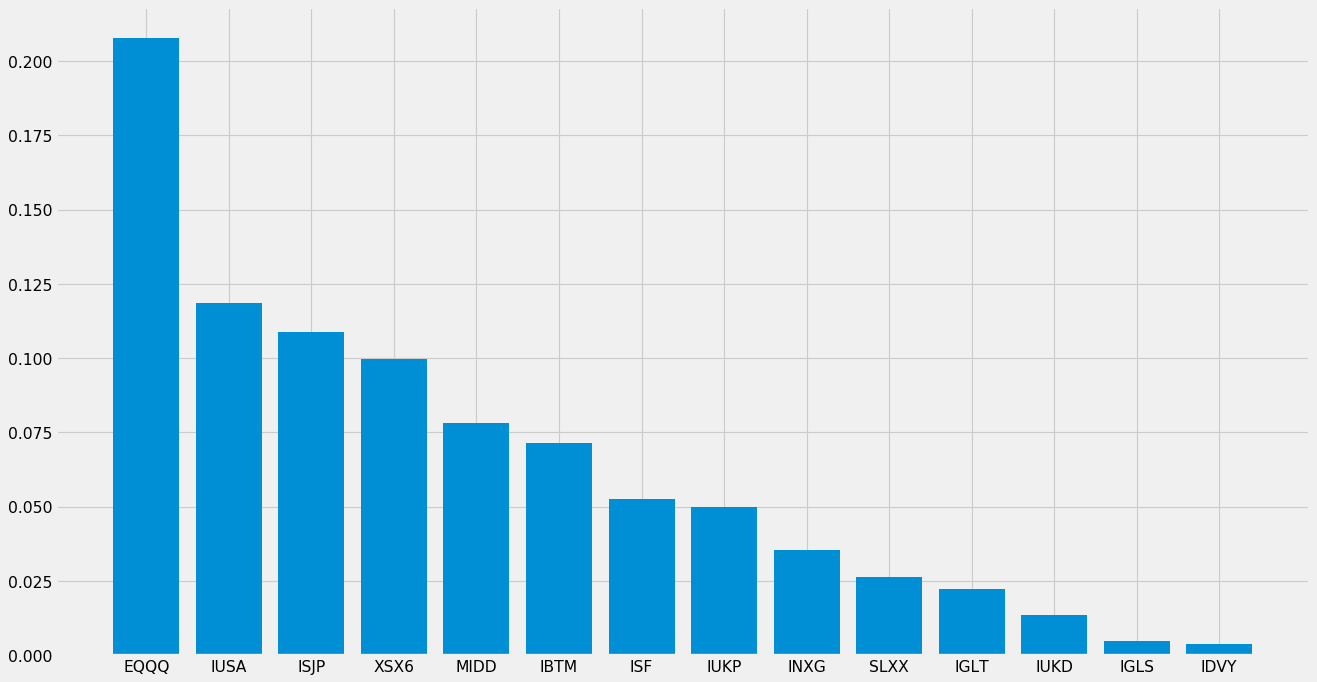

In [18]:
plt.figure(figsize=(18,10), dpi= 80)
plt.bar(range(len(return_lst)), [v[1] for v in return_lst], align='center')
plt.xticks(range(len(return_lst)), [v[0] for v in return_lst])
plt.show()

In [19]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [20]:
pd.plotting.register_matplotlib_converters()

In [21]:
def ffill_missing_dates(df):
    idx = pd.date_range(df.index.min(), df.index.max())
    df = df.reindex(idx, method='ffill')
    return df

In [22]:
def prophet_model(df):
    df = df.copy()
    df = df.rename(columns={'Close': 'y'})
    df['ds'] = df.index
    df.reset_index(inplace=True)
    df_model = Prophet()
    df_model.fit(df)
    df_forecast = df_model.make_future_dataframe(periods=13, freq='D')
    df_forecast = df_model.predict(df_forecast)
    df_forecast.set_index('ds', inplace=True)
    return df_forecast

In [23]:
def save_plot(df, df_forecast, symbol):
    plt.figure(figsize=(25, 10))
    plt.plot(df_forecast['yhat'], 'b-', label='yhat', linewidth=3)
    plt.plot(df.index, df['Close'], 'g-', label='price', linewidth=1)
    plt.fill_between(df_forecast.index, 
                     df_forecast.yhat_lower, 
                     df_forecast.yhat_upper,
                     color='gray', alpha=0.2)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(symbol)
    plt.savefig(f'{symbol}.png')


In [24]:
def buy_or_sell(price, df_forecast):
    
#     date  = df.index.max()
#     price = df.loc[ date , 'Close' ]
    yhat  = df_forecast.loc[ today , 'yhat' ]
    yhat_lower = df_forecast.loc[ today , 'yhat_lower' ]
    yhat_upper = df_forecast.loc[ today , 'yhat_upper' ]
    
    if price < yhat_lower:
        return 'strong buy'
    
    if price < yhat:
        return 'buy'
    
    if price > yhat_upper:
        return 'strong sell'
    
    if price > yhat:
        return 'sell'
    
    return 'no change'
    

In [25]:
%%capture
for k,v in stock_dct.items():
    df = v.historic_data
    df = ffill_missing_dates(df)
    df_forecast = prophet_model(df)
    save_plot(df, df_forecast, 'figures/' + k)
    v.buy_or_sell = buy_or_sell(float(v.meta['price']), df_forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

In [26]:
from collections import defaultdict

In [27]:
summary_dct = defaultdict(list)
for k,v in stock_dct.items():
    summary_dct['symbol'].append(k)
    summary_dct['age'].append(v.age)
    summary_dct['trend'].append(v.buy_or_sell)
    summary_dct['median_return'].append(v.median_return)

In [28]:
df = pd.DataFrame.from_records(summary_dct)

In [29]:
df.set_index('symbol', inplace=True)

In [30]:
df['gt10'] = df['age'] >= 10
df['gt5']  = df['age'] >= 5

In [31]:
df.sort_values(by=['gt10', 'gt5', 'trend', 'median_return'], ascending=False, inplace=True)

In [32]:
df[ df['trend'].str.contains('buy') ]

,age,median_return,trend,gt10,gt5
symbol,,,,,
MIDD,15.369863,0.078075,strong buy,True,True
ISF,19.279452,0.052678,strong buy,True,True
IUKP,12.394521,0.049831,strong buy,True,True
IUKD,13.758904,0.013552,strong buy,True,True
IDVY,13.778082,0.003654,buy,True,True
FTAL,7.284932,0.080360,buy,False,True
VHYL,6.210959,0.047435,buy,False,True
UKDV,7.430137,0.027346,buy,False,True
ERNS,5.810959,0.000599,buy,False,True


In [33]:
df[ df['trend'].str.contains('sell') ]

,age,median_return,trend,gt10,gt5
symbol,,,,,
EQQQ,14.019178,0.207787,strong sell,True,True
IUSA,17.400000,0.118528,strong sell,True,True
XSX6,10.353425,0.099854,strong sell,True,True
IBTM,12.605479,0.071382,strong sell,True,True
INXG,12.676712,0.035421,strong sell,True,True
SLXX,15.369863,0.026221,strong sell,True,True
IGLT,12.684932,0.022118,strong sell,True,True
IGLS,10.304110,0.004711,strong sell,True,True
ISJP,11.246575,0.108788,sell,True,True
